---
---
<center><h1> Problem Statement </h1></center>

---
---

Let's say you own an online blog publishing platform and you have signed up to a mix of amateur and professional authors and publications who regularly contribute blog posts related to various topics on your platform. The web traffic is basically, the number of articles in a given time frame and it varies a lot with respect to what time of the day it is, what day of the week it is and so on and how much web traffic your platform can withstand depends on the size of the servers that support your platform. If the traffic is more than what the servers can handle the website might show 404 error which is something we don't want to happen as it will make the visitors go away.

One solution to this problem is increase the number of servers. However the downside of this solution is the costs can go up which is again undesirable. One can dynamically allot servers based on the historical readers volume data and that brings us to the data science problem which is basically forecasting the number of articles read based on the historical data every hour for the next 2 weeks.

### Importing the Necessary Packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

# Reading in the necessary datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

# Checking the train and test dataset shapes. Below, we see that we have 190 (4560/24 hours) days in the train dataset
# while the test dataset requires prediction for the following 2 weeks.
train.shape, test.shape

((4560, 3), (336, 2))

In [ ]:
# Converting the date-time string to pandas datetime format and resetting the datasets' index to datetime.
train['datetime'] = pd.to_datetime(train['datetime'], format = '%Y-%m-%d %H:%M:%S')
test['datetime'] = pd.to_datetime(test['datetime'], format = '%Y-%m-%d %H:%M:%S')

train.set_index('datetime', inplace = True)
train.drop(['id'], axis = 1, inplace = True)
test.set_index('datetime', inplace = True)
test.drop(['id'], axis = 1, inplace = True)

# Consolidating the dates in a single dataframe for subsequent analysis
data = pd.concat([train, test])

In [ ]:
train.shape, test.shape

((4560, 1), (336, 0))

### Linear Regression


**Feature Creation**

In [ ]:
datetime = pd.Series(data.index)

# Creating datetime features
date_train = pd.DataFrame({# 'hour': datetime.dt.hour,
                           'dayofweek': datetime.dt.dayofweek})

# bins = [-1, 9, 23]
# group = [0, 1]
# date_train['timeofday'] = pd.cut(date_train['hour'], bins, labels = group)

bins = [-1, 4, 6]
group = [0, 1]
date_train['is_weekend'] = pd.cut(date_train['dayofweek'], bins, labels = group)
date_train.drop(['dayofweek'], axis = 1, inplace = True)

In [ ]:
date_train['count'] = data['total_articles_read'].values

In [ ]:
# Including lags as features to check the persistence of past values on future values. I have used gaps of 168 hours in my
# lag features so that when comparing future values, I'm looking at the same hour in the same day of the next week.

for i in range(336, 1848, 168):
    date_train["lag_{}".format(i)] = date_train['count'].shift(i)

# Capping Outliers
date_train['count'][date_train['count'] > 5000] = 5000

In [ ]:
date_train.tail()

,is_weekend,count,lag_336,lag_504,lag_672,lag_840,lag_1008,lag_1176,lag_1344,lag_1512,lag_1680
4891,0,NaN,2783.0,4966.0,2820.0,3102.0,3519.0,4235.0,3497.0,3492.0,3399.0
4892,0,NaN,2754.0,5158.0,2503.0,3242.0,3495.0,4149.0,3485.0,3659.0,3363.0
4893,0,NaN,2831.0,5465.0,2588.0,2928.0,3429.0,4043.0,3447.0,3644.0,3360.0
4894,0,NaN,2562.0,5548.0,2343.0,2842.0,3225.0,3784.0,3308.0,3413.0,3288.0
4895,0,NaN,2343.0,4858.0,2116.0,2413.0,2930.0,3282.0,2962.0,3059.0,2926.0


In [ ]:
# Splitting the data into train, validation and test
# Train data:
train_x = date_train.head(-336).dropna()
y = train_x[['count']]
X = train_x.drop(['count'], axis = 1)

# Test data:
test_x = date_train.tail(336).drop(['count'], axis = 1)

X.shape, y.shape, test_x.shape

((2880, 10), (2880, 1), (336, 10))

In [ ]:
# Defining a train test split function which takes the number of rows I want in my validation dataset and splits the X and
# y arrays provided accordingly.

def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """

    # get the index after which test set starts
    test_index = len(X) - test_size

    X_train = X[:test_index]
    y_train = y[:test_index]
    X_test = X[test_index:]
    y_test = y[test_index:]

    return X_train, X_test, y_train, y_test

train_x, val_x, train_y, val_y = timeseries_train_test_split(X, y, 336)
train_x.shape, val_x.shape, train_y.shape, val_y.shape

((2544, 10), (336, 10), (2544, 1), (336, 1))

In [ ]:
# Scaling the data in preparation for use on my model

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
val_x = scaler.transform(val_x)
test_x = scaler.transform(test_x)

In [ ]:
# Creating my model

from sklearn.linear_model import LinearRegression as LR
lr = LR()
lr.fit(train_x, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# Predicting over the train set and calculating error
train_predict = lr.predict(train_x)
k = np.sqrt(mean_squared_error(train_y, train_predict))
print('Training Root Mean Squared Log Error', k )

# Predicting over the validation Set and calculating error
val_predict = lr.predict(val_x)
k = np.sqrt(mean_squared_error(val_y, val_predict))
print('Validation Root Mean Squared Log Error', k)

Training Root Mean Squared Log Error 348.666777759978
Validation Root Mean Squared Log Error 907.4799029188375


Ordinarily, the data appears to be overfitting on the train dataset but considering the spike in articles read on new years eve as well as the unprecedented dips in articles read on the days surrounding this same day, all of which are contained in the validation dataset, I'm judging the strength of my model on how well it makes predictions on the train dataset. In hindsight, a good idea would have been to select my train_x and val_x at earlier dates to avoid the unusual activity around new years' eve.

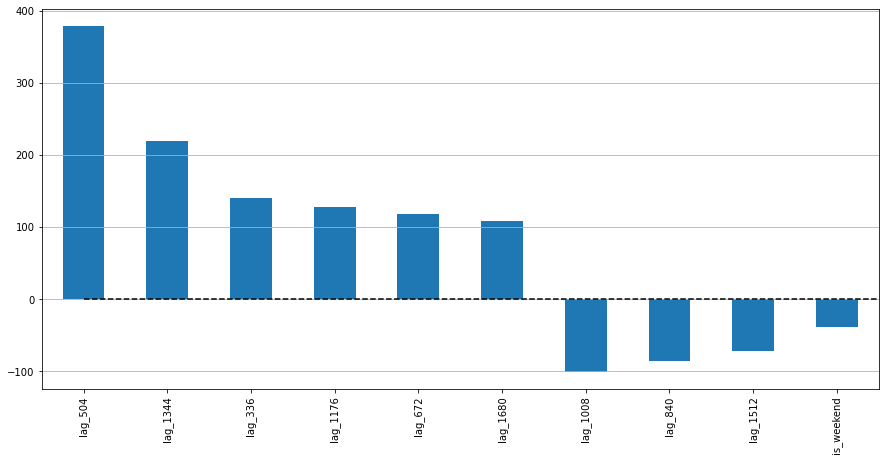

In [ ]:
# Defining a function to plot my model coefficients
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """

    coefs = pd.DataFrame(lr.coef_.T, X.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)

    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed')

plotCoefficients(lr)

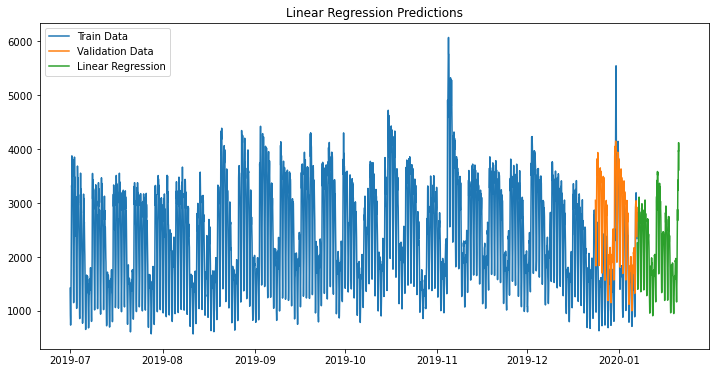

In [ ]:
# Predicting onto the test dataset
submission['total_articles_read'] = lr.predict(test_x)
submission.to_csv('Submission - LR (Weekly Lag feats).csv', index = False)

# Plotting my results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['total_articles_read'], label = 'Train Data')
plt.plot(train.index[4224:4560], val_predict, label = 'Validation Data')
plt.plot(test.index, submission['total_articles_read'], label = 'Linear Regression')
plt.legend(loc = 'best')
plt.title('Linear Regression Predictions')
plt.show()

### SVR

In [ ]:
# Importing the model
from sklearn.svm import SVR

svr = SVR(kernel = 'linear')
svr.fit(train_x, train_y)

# Predicting over the train Set and calculating error
train_predict = svr.predict(train_x)
k = np.sqrt(mean_squared_error(train_y, train_predict))
print('Training Root Mean Squared Log Error', k )

# Predicting over the validation Set and calculating error
val_predict = svr.predict(val_x)
k = np.sqrt(mean_squared_error(val_y, val_predict))
print('Validation Root Mean Squared Log Error', k)

Training Root Mean Squared Log Error 365.112679499414
Validation Root Mean Squared Log Error 902.6651752835579


In [ ]:
# Carrying out gridsearch using Time series split
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

ts_cv = TimeSeriesSplit(5)
param_grid = {'C': [.01, 0.1, 1, 10, 50, 100]}
grid_search = GridSearchCV(svr, param_grid, cv = ts_cv, n_jobs = -1, scoring = 'neg_mean_squared_error')
grid_search.fit(train_x, train_y)

print(grid_search.best_params_)
print(grid_search.best_score_)

grid_df = pd.DataFrame()
grid_df['Parameters'] = grid_search.cv_results_['params']
grid_df['split0_test_score'] = grid_search.cv_results_['split0_test_score']
grid_df['split1_test_score'] = grid_search.cv_results_['split1_test_score']
grid_df['split2_test_score'] = grid_search.cv_results_['split2_test_score']
grid_df['split3_test_score'] = grid_search.cv_results_['split3_test_score']
grid_df['mean_test_score'] = grid_search.cv_results_['mean_test_score']
grid_df

{'C': 1}
-165526.73125586673


,Parameters,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score
0,{'C': 0.01},-615277.103458,-823309.876739,-926169.205518,-536410.047472,-669202.395905
1,{'C': 0.1},-319537.340097,-285369.967280,-337919.878631,-67587.130605,-243671.696935
2,{'C': 1},-106594.725070,-205412.536719,-223944.030969,-77851.980870,-165526.731256
3,{'C': 10},-129269.540928,-223049.417476,-246815.797550,-128613.598613,-184479.222032
4,{'C': 50},-137945.058633,-226641.530441,-266684.226553,-149665.844929,-194026.642350
5,{'C': 100},-135304.410776,-227671.218797,-271880.714374,-155622.088372,-195674.143310


In [ ]:
svr = SVR(kernel = 'linear', C = 1)
svr.fit(train_x, train_y)

# Predicting over the train Set and calculating error
train_predict = svr.predict(train_x)
k = np.sqrt(mean_squared_error(train_y, train_predict))
print('Training Root Mean Squared Log Error', k )

# Predicting over the validation Set and calculating error
val_predict = svr.predict(val_x)
k = np.sqrt(mean_squared_error(val_y, val_predict))
print('Validation Root Mean Squared Log Error', k)

Training Root Mean Squared Log Error 365.112679499414
Validation Root Mean Squared Log Error 902.6651752835579


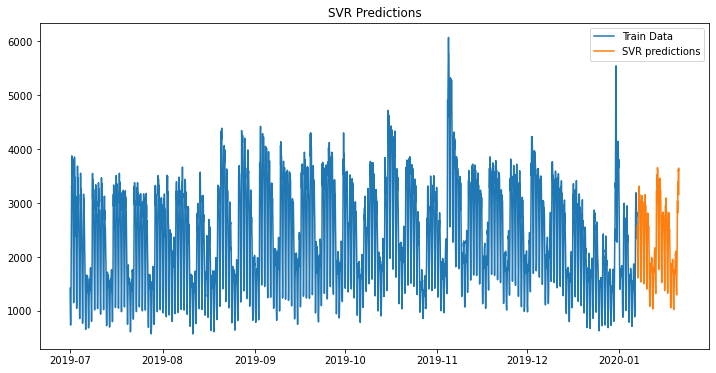

In [ ]:
# Predicting onto the test dataset
submission['total_articles_read'] = svr.predict(test_x)
submission.to_csv('Submission - Tuned SVM Regressor.csv', index = False)

# Plotting my results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['total_articles_read'], label = 'Train Data')
plt.plot(test.index, submission['total_articles_read'], label = 'SVR predictions')
plt.legend(loc = 'best')
plt.title('SVR Predictions')
plt.show()

Tuned SVR got a leaderboard score of 244.9661826538.

### Other Models

In [ ]:
# Importing the models
from sklearn.ensemble import RandomForestRegressor as RFR, GradientBoostingRegressor as GBR
from lightgbm import LGBMRegressor as LGR

In [ ]:
# Trying out Light Gradient Boost
lgbr = LGR(random_state = 42)
eval_set = [(val_x, val_y)]
lgbr.fit(train_x, train_y, eval_metric = "error", eval_set = eval_set, verbose = False, early_stopping_rounds=20)

# Predicting over the train Set and calculating error
train_preds = lgbr.predict(train_x)
score = np.sqrt(mean_squared_error(train_y, train_preds))
print('The RMSE on the training dataset is:', score)

# Predicting over the validation Set and calculating error
val_preds = lgbr.predict(val_x)
score = np.sqrt(mean_squared_error(val_y, val_preds))
print('The RMSE on the validation dataset is:', score)

The RMSE on the training dataset is: 355.12318330085344
The RMSE on the validation dataset is: 887.1623941268005


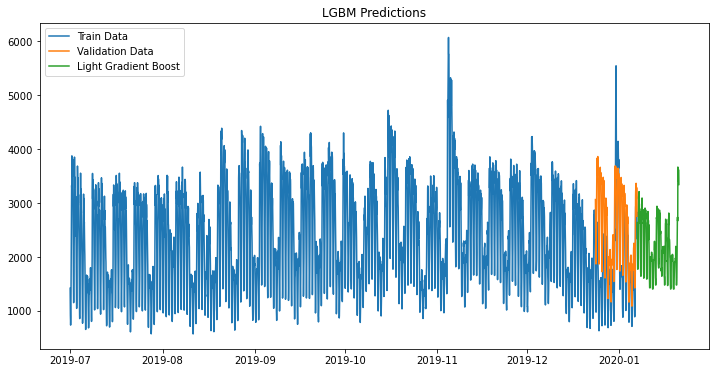

In [ ]:
# Predicting onto the test dataset
submission['total_articles_read'] = lgbr.predict(test_x)
submission.to_csv('Submission - Light Gradient Boost.csv', index = False)

# Plotting my results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['total_articles_read'], label = 'Train Data')
plt.plot(train.index[4224:4560], val_predict, label = 'Validation Data')
plt.plot(test.index, submission['total_articles_read'], label = 'Light Gradient Boost')
plt.legend(loc = 'best')
plt.title('LGBM Predictions')
plt.show()

Light GBM got a leaderboard score of 314.253900412324.

In [ ]:
# Trying out Random Forest Regressor
rfr = RFR(random_state = 42)
rfr.fit(train_x, train_y)

# Predicting over the train Set and calculating error
train_preds = rfr.predict(train_x)
score = np.sqrt(mean_squared_error(train_y, train_preds))
print('The RMSE on the training dataset is:', score)

# Predicting over the validation Set and calculating error
val_preds = rfr.predict(val_x)
score = np.sqrt(mean_squared_error(val_y, val_preds))
print('The RMSE on the validation dataset is:', score)

The RMSE on the training dataset is: 102.96447289515469
The RMSE on the validation dataset is: 924.8428680460239


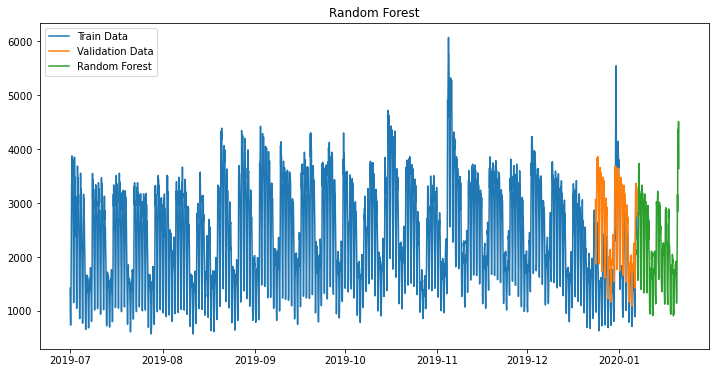

In [ ]:
# Predicting onto the test dataset
submission['total_articles_read'] = rfr.predict(test_x)
submission.to_csv('Submission - Random Forest.csv', index = False)

# Plotting my results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['total_articles_read'], label = 'Train Data')
plt.plot(train.index[4224:4560], val_predict, label = 'Validation Data')
plt.plot(test.index, submission['total_articles_read'], label = 'Random Forest')
plt.legend(loc = 'best')
plt.title('Random Forest')
plt.show()

Random Forest got a leaderboard score of 220.316809189198

In [ ]:
# Trying out Gradient Boost
gbr = GBR(random_state = 42)
gbr.fit(train_x, train_y)

# Predicting over the train Set and calculating error
train_preds = gbr.predict(train_x)
score = np.sqrt(mean_squared_error(train_y, train_preds))
print('The RMSE on the training dataset is:', score)

# Predicting over the validation Set and calculating error
val_preds = gbr.predict(val_x)
score = np.sqrt(mean_squared_error(val_y, val_preds))
print('The RMSE on the validation dataset is:', score)

The RMSE on the training dataset is: 265.724001535078
The RMSE on the validation dataset is: 913.2530388445989


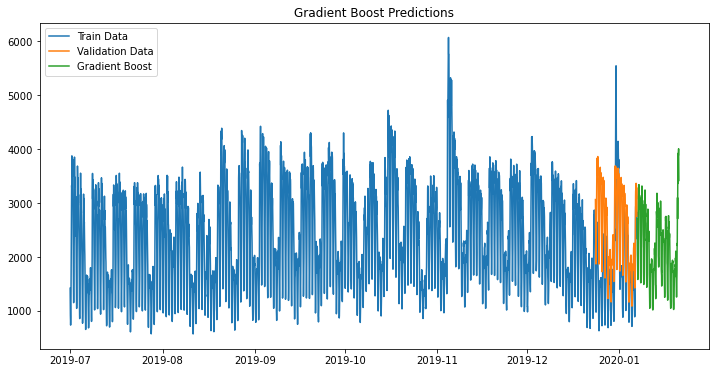

In [ ]:
# Predicting onto the test dataset
submission['total_articles_read'] = gbr.predict(test_x)
submission.to_csv('Submission - Gradient Boost.csv', index = False)

# Plotting my results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['total_articles_read'], label = 'Train Data')
plt.plot(train.index[4224:4560], val_predict, label = 'Validation Data')
plt.plot(test.index, submission['total_articles_read'], label = 'Gradient Boost')
plt.legend(loc = 'best')
plt.title('Gradient Boost Predictions')
plt.show()

Gradient Boost Regressor got a leaderboard score of 239.99823584802576.